# 音声をメルスペクトログラムに変換する

このノートブックは、鳥の音声データをメルスペクトログラムに変換し、後の機械学習モデルのための特徴量を生成します。

In [8]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

## パラメータの設定

メルスペクトログラム変換のためのパラメータ設定

In [9]:
# メルスペクトログラムの設定値
SR = 32000  # サンプリング周波数
N_FFT = 1024  # FFTのウィンドウサイズ
N_MELS = 128  # メルフィルタバンクの数
HOP_LENGTH = 512  # フレーム間のずれ
FMIN = 50  # 最小周波数
FMAX = SR // 2  # 最大周波数

# 音声の長さ設定（5秒）
DURATION = 5  # 秒単位
# フレーム数を計算（5秒の音声に対応するフレーム数）
N_FRAMES = 1 + int(DURATION * SR / HOP_LENGTH)

## データの読み込み

In [10]:
# トレーニングデータの読み込み（上位5000行のみ）
df_train = pd.read_csv('/home/data/train.csv')
df_train = df_train.head(5000)
print(f'学習データ数: {len(df_train)}')
df_train.head()

学習データ数: 5000


,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [11]:
# ユニークなクラス（鳥の種類）の数を確認
print(f'ユニークなクラス数: {df_train["primary_label"].nunique()}')
print(df_train['primary_label'].value_counts().head(10))

ユニークなクラス数: 81
primary_label
banana     610
bbwduc     424
bobfly1    421
amekes     409
blbgra1    380
bkmtou1    311
blhpar1    230
bkcdon     176
babwar     167
baymac     149
Name: count, dtype: int64


## 音声データをメルスペクトログラムに変換する関数

In [12]:
def audio_to_melspectrogram(audio_path):
    """
    音声ファイルからメルスペクトログラムを生成する
    
    Parameters:
        audio_path (str): 音声ファイルへのパス
        
    Returns:
        np.ndarray: メルスペクトログラム
    """
    try:
        # 音声データの読み込み
        y, _ = librosa.load(audio_path, sr=SR)
        
        # 音声の正規化 (min-max scaling)
        if len(y) > 0:
            y_min, y_max = np.min(y), np.max(y)
            if y_min != y_max:  # 分母が0にならないように確認
                y = (y - y_min) / (y_max - y_min)
        
        # 5秒分のサンプル数を計算
        target_length = SR * DURATION
        
        # 長さを調整（5秒に満たない場合はパディング、5秒以上の場合は切り取り）
        if len(y) < target_length:
            # 0でパディング
            y = np.pad(y, (0, target_length - len(y)), 'constant')
        else:
            # 先頭から5秒分を使用
            y = y[:target_length]
        
        # メルスペクトログラムの計算
        melspec = librosa.feature.melspectrogram(
            y=y,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
            fmin=FMIN,
            fmax=FMAX
        )
        
        # 対数変換
        melspec = librosa.power_to_db(melspec, ref=np.max)
        
        return melspec
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

## メルスペクトログラムの可視化テスト

元の音声の長さ: 98.85秒 (3163308サンプル)
メルスペクトログラムの形状: (128, 313)
メルスペクトログラムのフレーム数: 313 (目標: 313)


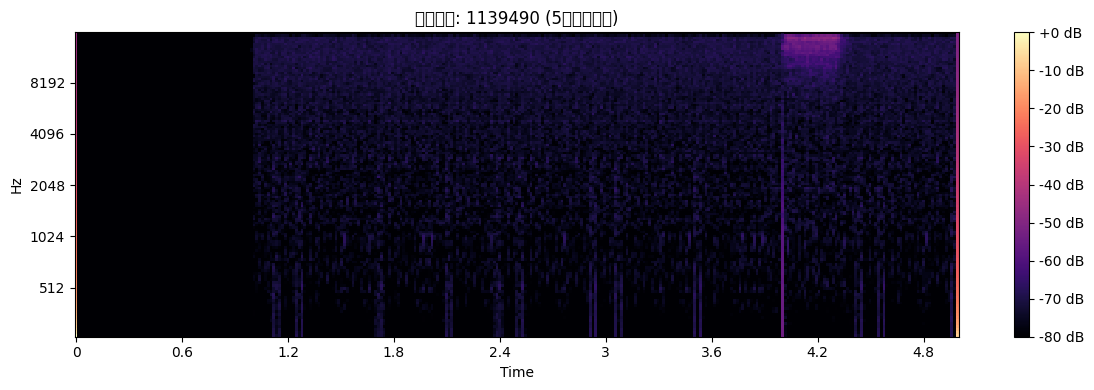

In [14]:
# サンプルとして1つの音声ファイルを取得
sample_filepath = df_train.iloc[0]['filename']
sample_audio_path = os.path.join('/home/data/train_audio', sample_filepath)

# 音声データを読み込み、長さを確認
y_original, _ = librosa.load(sample_audio_path, sr=SR)
print(f"元の音声の長さ: {len(y_original) / SR:.2f}秒 ({len(y_original)}サンプル)")

# メルスペクトログラムを生成
sample_melspec = audio_to_melspectrogram(sample_audio_path)
print(f"メルスペクトログラムの形状: {sample_melspec.shape}")
print(f"メルスペクトログラムのフレーム数: {sample_melspec.shape[1]} (目標: {N_FRAMES})")

# メルスペクトログラムの可視化
plt.figure(figsize=(12, 4))
librosa.display.specshow(
    sample_melspec, 
    sr=SR, 
    hop_length=HOP_LENGTH,
    x_axis='time', 
    y_axis='mel', 
    fmin=FMIN, 
    fmax=FMAX
)
plt.colorbar(format='%+2.0f dB')
plt.title(f'鳥の種類: {df_train.iloc[0]["primary_label"]} (5秒に正規化)')
plt.tight_layout()
plt.show()

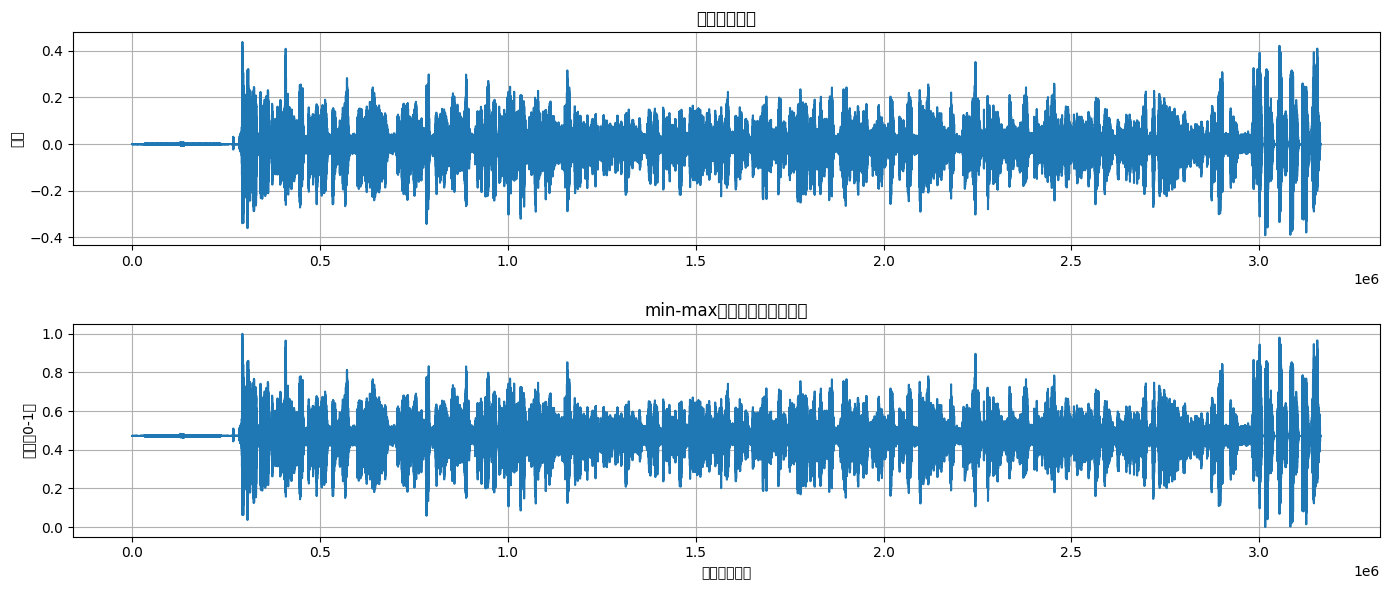

In [15]:
# min-max正規化前後の音声波形を可視化して比較
y_original, _ = librosa.load(sample_audio_path, sr=SR)
y_normalized = y_original.copy()

# min-max正規化
y_min, y_max = np.min(y_original), np.max(y_original)
if y_min != y_max:
    y_normalized = (y_original - y_min) / (y_max - y_min)

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(y_original)
plt.title('元の音声波形')
plt.ylabel('振幅')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(y_normalized)
plt.title('min-max正規化後の音声波形')
plt.ylabel('振幅（0-1）')
plt.xlabel('サンプル番号')
plt.grid(True)

plt.tight_layout()
plt.show()

## すべての音声ファイルをメルスペクトログラムに変換

In [16]:
# 出力ディレクトリの作成
output_dir = "/home/working/exp1/output"
os.makedirs(output_dir, exist_ok=True)

In [18]:
# 全ての音声ファイルをメルスペクトログラムに変換
mel_data = {}

for idx, row in tqdm(df_train.iterrows(), total=len(df_train), desc="メルスペクトログラム変換中"):
    audio_path = os.path.join('/home/data/train_audio', row['filename'])
    melspec = audio_to_melspectrogram(audio_path)
    
    if melspec is not None:
        mel_data[idx] = melspec

メルスペクトログラム変換中:   0%|          | 0/5000 [00:00<?, ?it/s]

## メルスペクトログラムデータの保存

In [19]:
# 結果を保存
output_file = os.path.join(output_dir, "meldata.npy")
np.save(output_file, mel_data)
print(f"メルスペクトログラムデータを保存しました: {output_file}")

メルスペクトログラムデータを保存しました: /home/working/exp1/output/meldata.npy


In [20]:
# 保存したデータを確認
loaded_mel_data = np.load(output_file, allow_pickle=True).item()
print(f"保存されたデータポイント数: {len(loaded_mel_data)}")

# サンプルのメルスペクトログラムの形状を確認
sample_idx = list(loaded_mel_data.keys())[0]
print(f"サンプルメルスペクトログラムの形状: {loaded_mel_data[sample_idx].shape}")

# すべてのサンプルが5秒（N_FRAMES）になっているか確認
expected_frames = 1 + int(DURATION * SR / HOP_LENGTH)
consistent_shape = all(mel.shape[1] == expected_frames for mel in loaded_mel_data.values())
print(f"すべてのサンプルが同じフレーム数 ({expected_frames}) を持っているか: {consistent_shape}")

保存されたデータポイント数: 5000
サンプルメルスペクトログラムの形状: (128, 313)
すべてのサンプルが同じフレーム数 (313) を持っているか: True
